# Задача 1: предсказание уровня удовлетворённости сотрудника   
Для этой задачи заказчик предоставил данные с признаками:   
`id` — уникальный идентификатор сотрудника;      
`dept` — отдел, в котором работает сотрудник;   
`level` — уровень занимаемой должности;   
`workload` — уровень загруженности сотрудника;   
`employment_years` — длительность работы в компании (в годах);   
`last_year_promo` — показывает, было ли повышение за последний год;   
`last_year_violations` — показывает, нарушал ли сотрудник трудовой договор за последний год;   
`supervisor_evaluation` — оценка качества работы сотрудника, которую дал руководитель;   
`salary` — ежемесячная зарплата сотрудника;   
`job_satisfaction_rate` — уровень удовлетворённости сотрудника работой в компании, целевой признак.

In [1]:
!cp -r ./datasets /

cp: cannot create regular file '/datasets/ds_bert/bert_config.json': Read-only file system
cp: cannot create regular file '/datasets/ds_bert/rubert_model.bin': Read-only file system
cp: cannot create regular file '/datasets/ds_bert/vocab.txt': Read-only file system
cp: cannot create regular file '/datasets/hotel_test.csv': Read-only file system
cp: cannot create regular file '/datasets/hotel_train.csv': Read-only file system
cp: cannot create regular file '/datasets/toxic_comments.csv': Read-only file system


In [2]:
!pip install -q phik

In [3]:
# Импорт библиотек для анализа данных
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import phik
sns.set()

# Импорт библиотек и модулей из scikit-learn
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import mean_absolute_error, roc_auc_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import make_scorer

from xgboost import XGBClassifier

## Шаг 1. Загрузка данных

In [4]:
# Загрузка файлов данных
train_data_path = '/datasets/train_job_satisfaction_rate.csv'
test_features_path = '/datasets/test_features.csv'
test_target_path = '/datasets/test_target_job_satisfaction_rate.csv'

In [5]:
# Чтение данных
train_data = pd.read_csv(train_data_path)
test_features = pd.read_csv(test_features_path)
test_target = pd.read_csv(test_target_path)

In [6]:
train_data.sample(n=5)

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
3067,213691,technology,middle,low,6,no,no,4,34800,0.80
419,969419,marketing,junior,medium,1,no,no,3,30000,0.41
1041,647159,technology,middle,medium,2,no,no,3,39600,0.18
2438,509837,sales,junior,medium,2,no,no,2,24000,0.42
3688,158096,hr,sinior,medium,3,no,no,4,61200,0.74


In [7]:
test_target.sample(n=5)

,id,job_satisfaction_rate
123,165789,0.64
912,860884,0.38
1642,497886,0.39
1758,905027,0.46
231,100692,0.69


In [8]:
train_data.sample(n=5)

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
348,956451,sales,sinior,medium,5,no,no,3,58800,0.29
2833,883060,marketing,junior,low,2,no,no,3,13200,0.26
1038,263920,technology,middle,medium,5,no,no,4,39600,0.67
724,654930,sales,sinior,medium,10,no,no,4,51600,0.93
1610,886030,hr,middle,medium,5,no,yes,1,38400,0.19


In [9]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB


In [10]:
train_data.describe(include='all')

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
count,4000.000000,3994,3996,4000,4000.000000,4000,4000,4000.000000,4000.000000,4000.000000
unique,NaN,5,3,3,NaN,2,2,NaN,NaN,NaN
top,NaN,sales,junior,medium,NaN,no,no,NaN,NaN,NaN
freq,NaN,1512,1894,2066,NaN,3880,3441,NaN,NaN,NaN
mean,544957.621000,NaN,NaN,NaN,3.718500,NaN,NaN,3.476500,33926.700000,0.533995
std,257883.104622,NaN,NaN,NaN,2.542513,NaN,NaN,1.008812,14900.703838,0.225327
min,100954.000000,NaN,NaN,NaN,1.000000,NaN,NaN,1.000000,12000.000000,0.030000
25%,322836.750000,NaN,NaN,NaN,2.000000,NaN,NaN,3.000000,22800.000000,0.360000
50%,534082.500000,NaN,NaN,NaN,3.000000,NaN,NaN,4.000000,30000.000000,0.560000
75%,771446.000000,NaN,NaN,NaN,6.000000,NaN,NaN,4.000000,43200.000000,0.710000


In [11]:
test_features.sample(n=5)

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
1629,526673,marketing,middle,low,2,yes,no,4,20400
1835,583252,hr,junior,medium,2,no,no,3,22800
300,263428,purchasing,junior,low,1,no,no,4,15600
1437,679133,marketing,middle,low,7,no,no,2,25200
837,443496,sales,junior,medium,2,no,no,5,21600


In [12]:
test_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


In [13]:
test_features.describe(include='all')

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
count,2000.000000,1998,1999,2000,2000.000000,2000,2000,2000.000000,2000.000000
unique,NaN,6,3,4,NaN,2,2,NaN,NaN
top,NaN,sales,junior,medium,NaN,no,no,NaN,NaN
freq,NaN,763,974,1043,NaN,1937,1738,NaN,NaN
mean,552765.213500,NaN,NaN,NaN,3.666500,NaN,NaN,3.526500,34066.800000
std,253851.326129,NaN,NaN,NaN,2.537222,NaN,NaN,0.996892,15398.436729
min,100298.000000,NaN,NaN,NaN,1.000000,NaN,NaN,1.000000,12000.000000
25%,339052.000000,NaN,NaN,NaN,1.000000,NaN,NaN,3.000000,22800.000000
50%,550793.000000,NaN,NaN,NaN,3.000000,NaN,NaN,4.000000,30000.000000
75%,765763.750000,NaN,NaN,NaN,6.000000,NaN,NaN,4.000000,43200.000000


In [14]:
test_target.sample(n=5)

,id,job_satisfaction_rate
378,380255,0.81
1067,852793,0.76
1856,622083,0.78
969,361578,0.44
1259,305653,0.11


In [15]:
test_target.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 31.4 KB


In [16]:
test_target.describe(include='all')

,id,job_satisfaction_rate
count,2000.000000,2000.00000
mean,552765.213500,0.54878
std,253851.326129,0.22011
min,100298.000000,0.03000
25%,339052.000000,0.38000
50%,550793.000000,0.58000
75%,765763.750000,0.72000
max,999029.000000,1.00000


**Вывод:**

Тренировочные данные
* Всего записей: 4000
* Пропущенные значения обнаружены в столбцах dept и level
* Типы данных: числовые и категориальные

Описательная статистика показывает разнообразие значений в каждом столбце.

Тестовые данные (признаки)
* Всего записей: 2000
* Пропущенные значения обнаружены в столбцах dept и level

Типы данных аналогичны тренировочным данным.

## Шаг 2. Предобработка данных

In [17]:
# Проверка на заполненные пропуски
train_data.isnull().sum(), test_features.isnull().sum()

(id                       0
 dept                     6
 level                    4
 workload                 0
 employment_years         0
 last_year_promo          0
 last_year_violations     0
 supervisor_evaluation    0
 salary                   0
 job_satisfaction_rate    0
 dtype: int64,
 id                       0
 dept                     2
 level                    1
 workload                 0
 employment_years         0
 last_year_promo          0
 last_year_violations     0
 supervisor_evaluation    0
 salary                   0
 dtype: int64)

**Вывод:**

Заполним пропуски в pipeline

## Шаг 3. Исследовательский анализ данных

In [18]:
numerical_features = train_data.select_dtypes(include=['int64', 'float64']).drop(['id'], axis=1)
quantitative_vars = numerical_features.columns

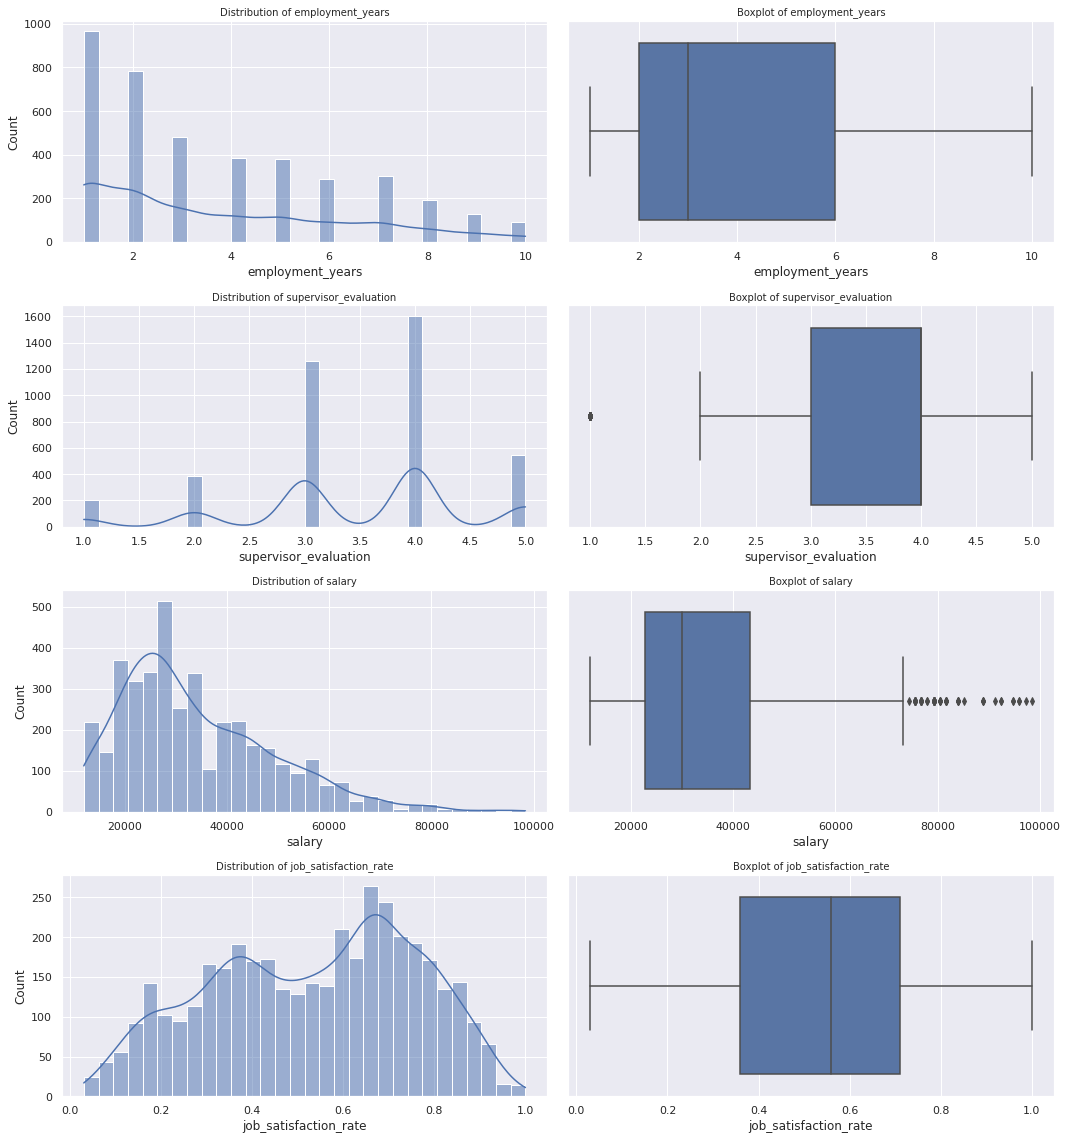

In [19]:
# Построим гистограммы и боксплоты для количественных переменных
fig, axes = plt.subplots(nrows=len(quantitative_vars), ncols=2,
                         figsize=(15, 4 * len(quantitative_vars)))

for i, var in enumerate(quantitative_vars):
    sns.histplot(numerical_features[var], bins=30, ax=axes[i, 0], kde=True)
    axes[i, 0].set_title(f'Distribution of {var}', fontsize=10)
    sns.boxplot(x=numerical_features[var], ax=axes[i, 1])
    axes[i, 1].set_title(f'Boxplot of {var}', fontsize=10)
    plt.tight_layout()

plt.show()

Числовые признаки:

* employment_years: Распределение смещено влево, что указывает на большое количество сотрудников с меньшим стажем работы

* supervisor_evaluation: Преобладает оценка 4

* salary: Распределение смещено вправо, что указывает на большее количество сотрудников с нижним диапазоном зарплат

* job_satisfaction_rate: Распределение близко к равномерному, но с некоторыми пиками

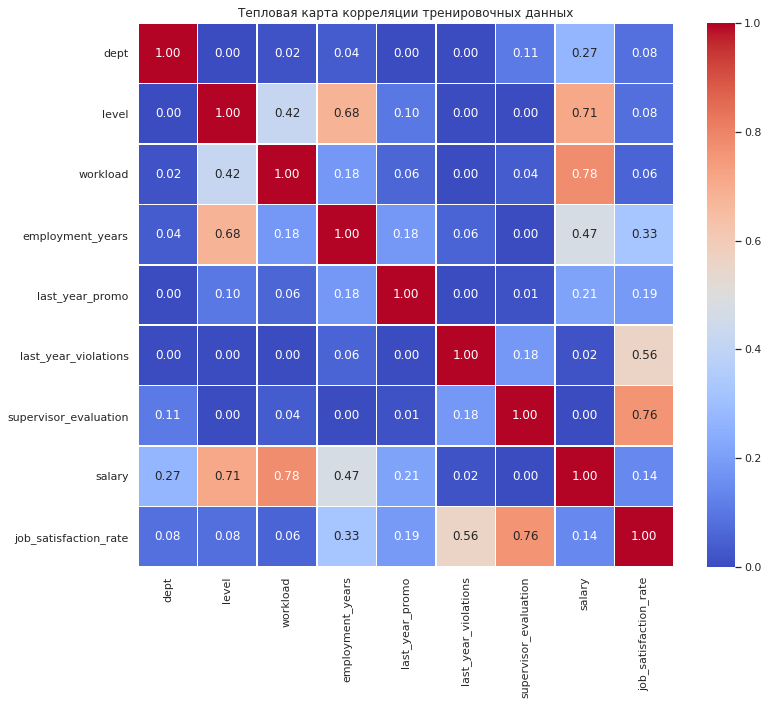

In [20]:
# Построим тепловую карту корреляций
corr_matrix = train_data.drop('id', axis=1).phik_matrix(interval_cols=['salary',
                                                                       'job_satisfaction_rate',
                                                                       'employment_years'])


plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm",
            linewidths=0.5, fmt='.2f')
plt.title('Тепловая карта корреляции тренировочных данных')
plt.show();

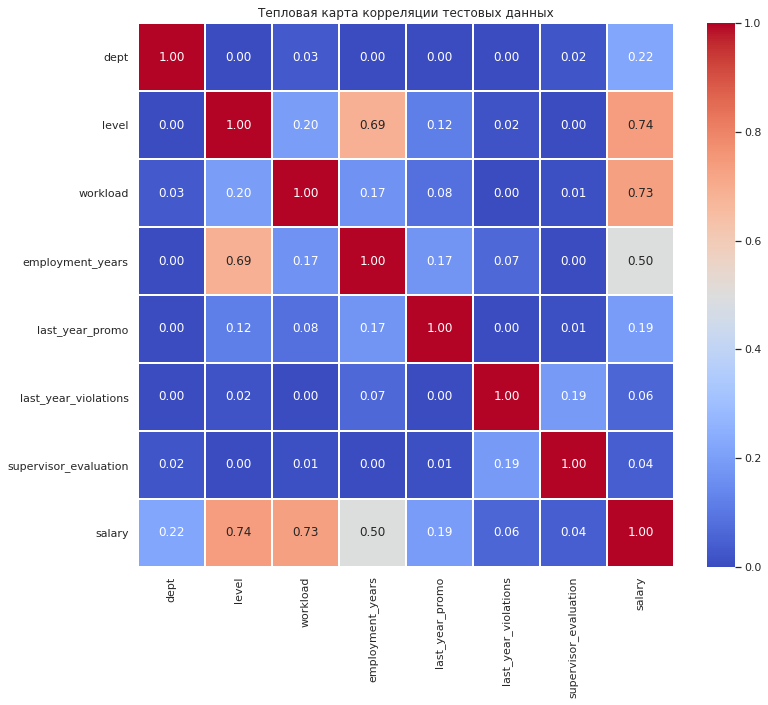

In [21]:
# Построим тепловую карту корреляций
corr_matrix = test_features.drop('id', axis=1).phik_matrix(interval_cols=['salary',
                                                                       'job_satisfaction_rate',
                                                                       'employment_years'])

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm",
            linewidths=0.5, fmt='.2f')
plt.title('Тепловая карта корреляции тестовых данных')
plt.show();

Наблюдаем сильную положительную связь между supervisor_evaluation и job_satisfaction_rate.

Можно сделать промежуточный вывод, что, чем выше оценивает сотрудника руководитель, тем больше он доволен работой

Возможны послабления в некоторых вещах, либо повышение зарплаты и т.д.

#### Тренировочные данные

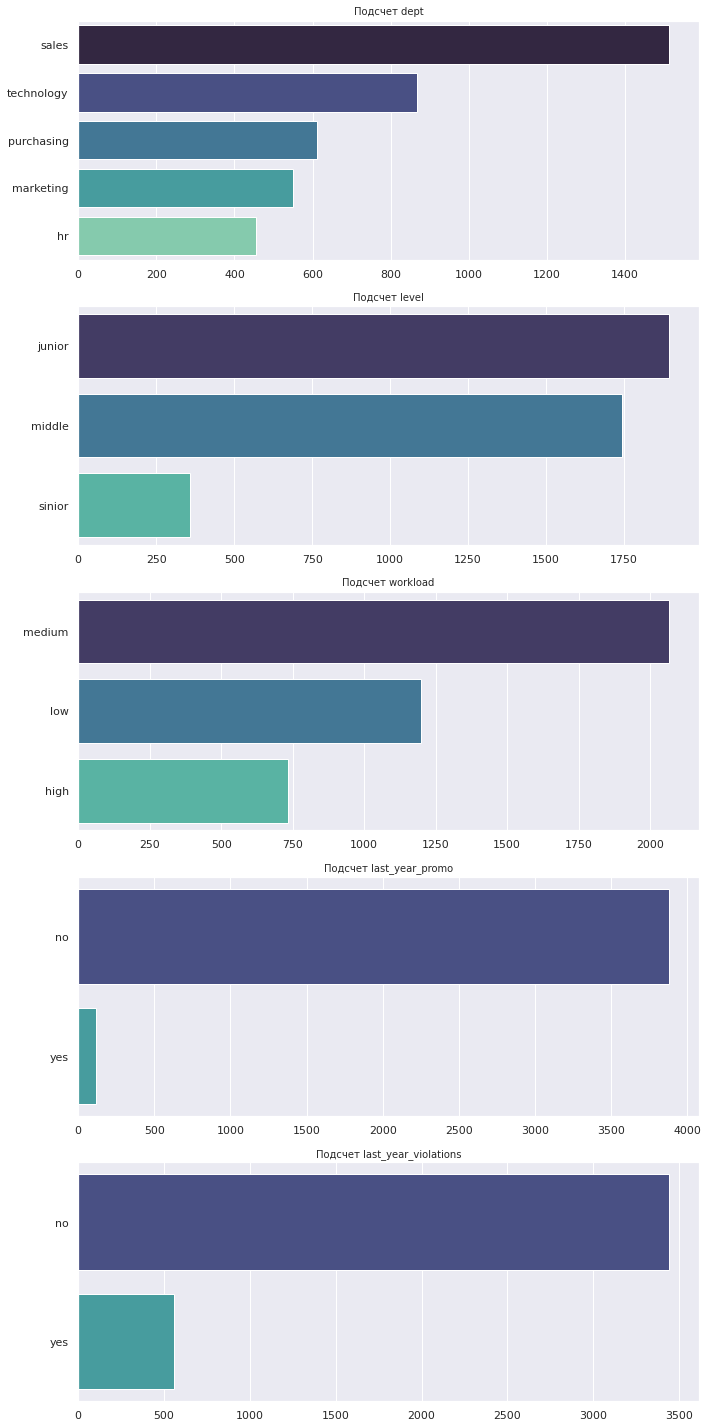

In [22]:
# Список категориальных переменных для исследования
categorical_features = train_data.select_dtypes(include=['object'])
categorical_columns = categorical_features.columns

# Построим столбчатые диаграммы для категориальных переменных
fig, axes = plt.subplots(nrows=len(categorical_columns), ncols=1, figsize=(10, 4 * len(categorical_columns)))

for i, var in enumerate(categorical_columns):
    sns.countplot(y=categorical_features[var], ax=axes[i],
                  order=categorical_features[var].value_counts().index,
                  palette='mako')
    axes[i].set_title(f'Подсчет {var}', fontsize=10)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    plt.tight_layout()

plt.show()

Категориальные признаки:

* dept: Больше всего сотрудников в отделе продаж, затем идут технологии и HR

* level: Большинство сотрудников находятся на должности младшего уровня (junior)

* workload: Средний уровень загруженности является наиболее частым

* last_year_promo и last_year_violations: В большинстве случаев ответ "нет"

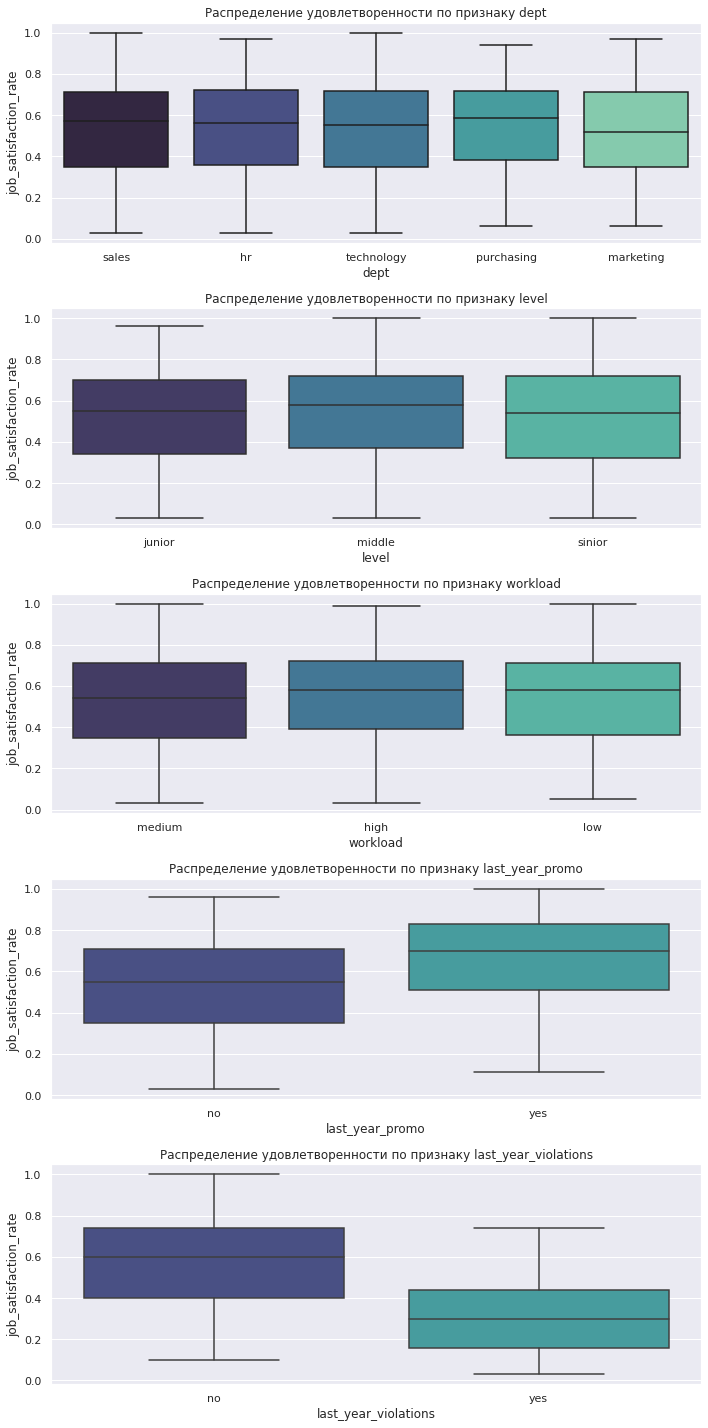

In [23]:
# Анализ категориальных признаков
categorical_features = train_data.select_dtypes(include=['object']).columns

# Построение графиков для категориальных признаков
fig, axes = plt.subplots(nrows=len(categorical_features), ncols=1, figsize=(10, 20))
for i, col in enumerate(categorical_features):
    sns.boxplot(x=col, y='job_satisfaction_rate', data=train_data, ax=axes[i], palette='mako')
    axes[i].set_title(f'Распределение удовлетворенности по признаку {col}')

plt.tight_layout()
plt.show()

#### Тестовые данные

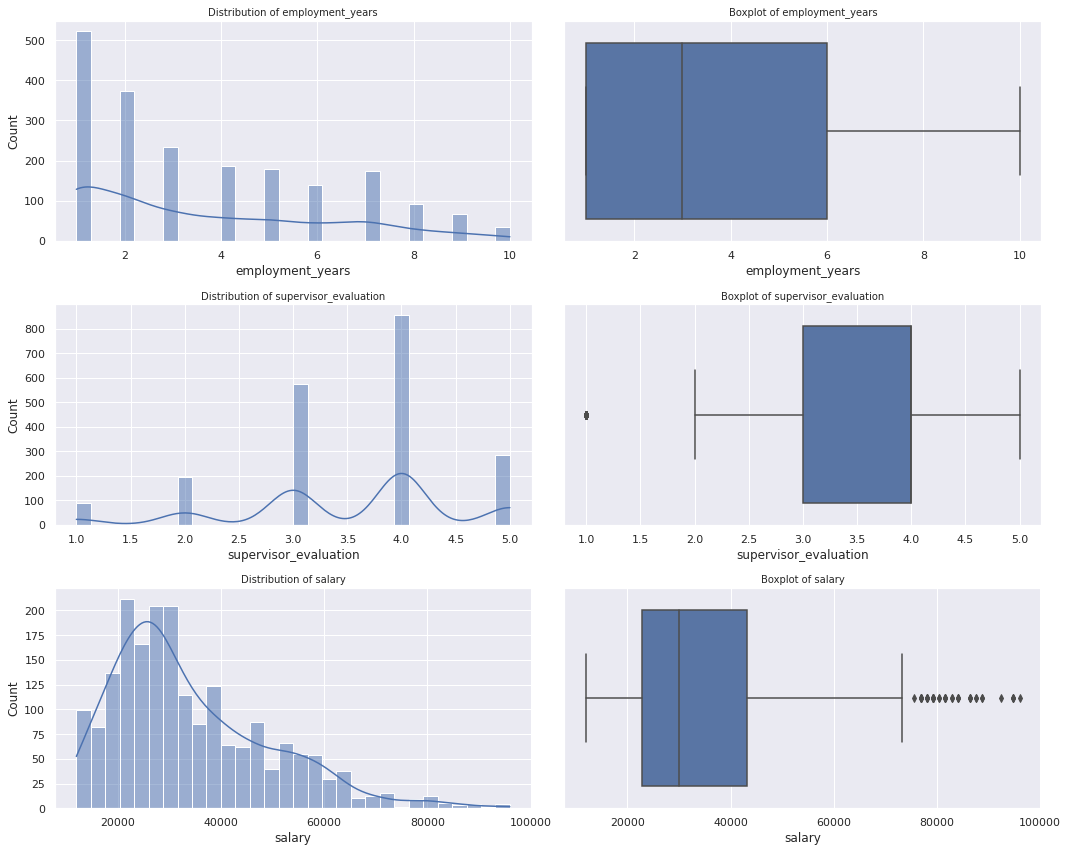

In [24]:
numerical_features = test_features.select_dtypes(include=['int64', 'float64']).drop(['id'], axis=1)
quantitative_vars = numerical_features.columns

# Построим гистограммы и боксплоты для количественных переменных
fig, axes = plt.subplots(nrows=len(quantitative_vars), ncols=2,
                         figsize=(15, 4 * len(quantitative_vars)))

for i, var in enumerate(quantitative_vars):
    sns.histplot(numerical_features[var], bins=30, ax=axes[i, 0], kde=True)
    axes[i, 0].set_title(f'Distribution of {var}', fontsize=10)
    sns.boxplot(x=numerical_features[var], ax=axes[i, 1])
    axes[i, 1].set_title(f'Boxplot of {var}', fontsize=10)
    plt.tight_layout()

plt.show()

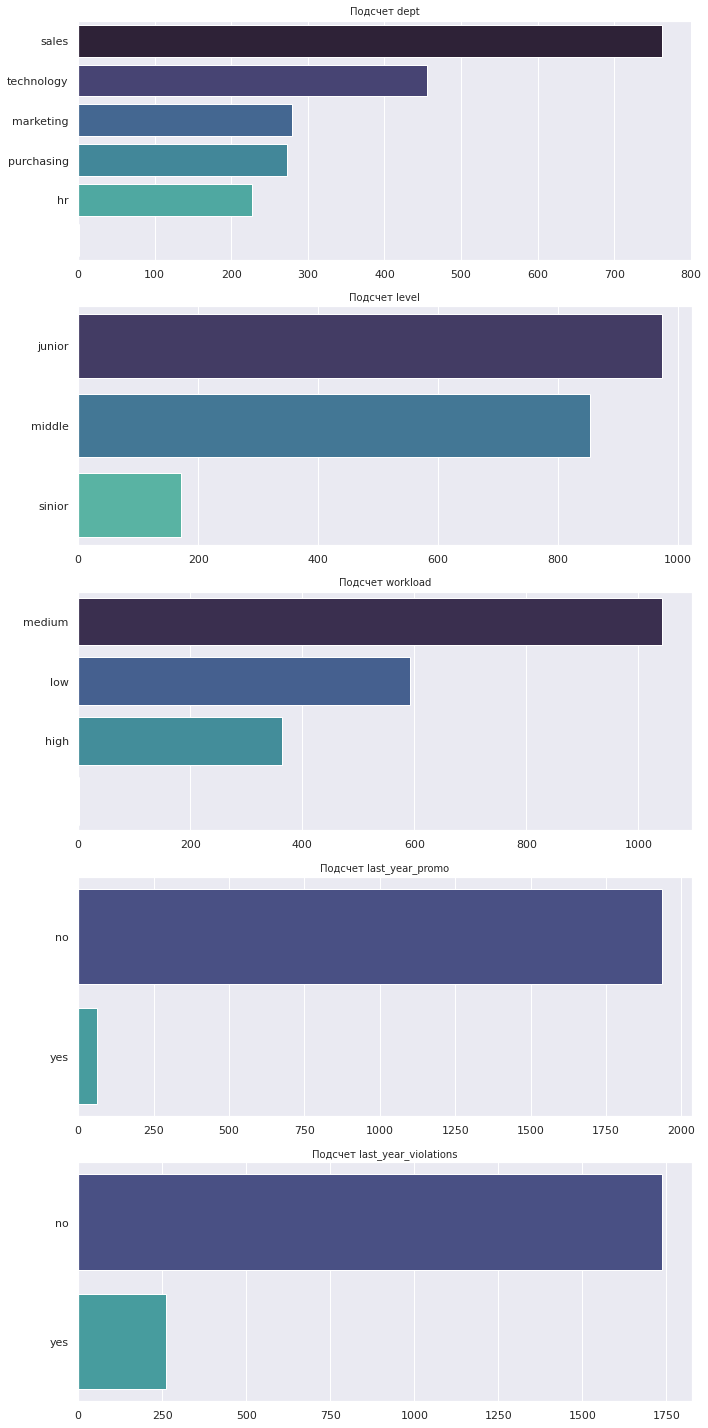

In [25]:
# Список категориальных переменных для исследования
categorical_features = test_features.select_dtypes(include=['object'])
categorical_columns = categorical_features.columns

# Построим столбчатые диаграммы для категориальных переменных
fig, axes = plt.subplots(nrows=len(categorical_columns), ncols=1, figsize=(10, 4 * len(categorical_columns)))

for i, var in enumerate(categorical_columns):
    sns.countplot(y=categorical_features[var], ax=axes[i],
                  order=categorical_features[var].value_counts().index,
                  palette='mako')
    axes[i].set_title(f'Подсчет {var}', fontsize=10)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    plt.tight_layout()

plt.show()

Категориальные признаки:

* dept: Больше всего сотрудников в отделе продаж, затем идут технологии и HR

* level: Большинство сотрудников находятся на должности младшего уровня (junior)

* workload: Средний уровень загруженности является наиболее частым

* last_year_promo и last_year_violations: В большинстве случаев ответ "нет"

Наблюдаем лишние категории. Вероятно, это пропуски, в пайплайне они будут игнорироваться

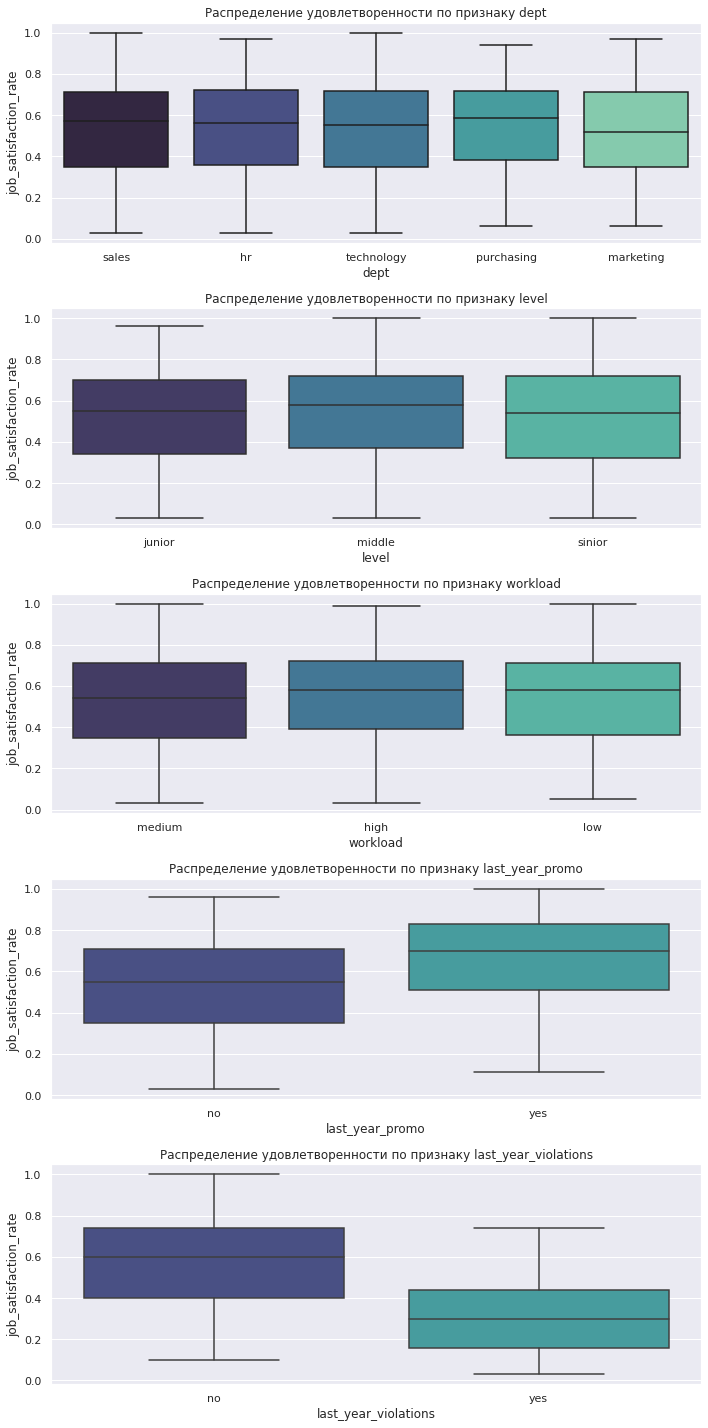

In [26]:
# Анализ категориальных признаков
categorical_features = test_features.select_dtypes(include=['object']).columns

# Построение графиков для категориальных признаков
fig, axes = plt.subplots(nrows=len(categorical_features), ncols=1, figsize=(10, 20))
for i, col in enumerate(categorical_features):
    sns.boxplot(x=col, y='job_satisfaction_rate', data=train_data, ax=axes[i], palette='mako')
    axes[i].set_title(f'Распределение удовлетворенности по признаку {col}')

plt.tight_layout()
plt.show()

#### Выводы

Графики показывают распределение уровня удовлетворенности сотрудников в зависимости от различных категориальных признаков:

* Отдел (dept): Почти не влияет на удовлетворенность
* Уровень должности (level): Почти не влияет на удовлетворенность
* Уровень загруженности (workload): Загруженность почти не влияет на удовлетворенность (можно провести статистический тест для подтверждения)
* Повышение за последний год (last_year_promo) и Нарушения за последний год (last_year_violations): Эти факторы также влияют на удовлетворенность сотрудников

После сравнения выборок, можно сделать вывод, что они схожи

Вывод

* Заполнение пропусков: Пропущенные значения в dept и level можно заполнить наиболее часто встречающимися значениями
* Кодирование категориальных признаков: Необходимо закодировать категориальные признаки для использования в моделях машинного обучения
* Масштабирование числовых признаков: Некоторые модели, например линейные, чувствительны к масштабу признаков

## Шаг 4. Подготовка данных

In [27]:
# Определение числовых и категориальных столбцов
numerical_cols = train_data.select_dtypes(include=['int64', 'float64']).columns.drop(['id', 'job_satisfaction_rate'])
categorical_cols = train_data.select_dtypes(include=['object']).columns

# Определение ранговых (порядковых) признаков
ordinal_cols = ['level', 'workload']

# Отдельный список для остальных категориальных признаков
nominal_cols = [col for col in categorical_cols if col not in ordinal_cols]

# Пайплайн для числовых признаков
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('scaler', StandardScaler())
])

# Пайплайн для ранговых категориальных признаков
ordinal_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ordinal', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=5))
])

# Пайплайн для остальных категориальных признаков
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Предобработка для числовых, ранговых и остальных категориальных данных
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('ordinal', ordinal_transformer, ordinal_cols),
        ('cat', categorical_transformer, nominal_cols)
])

# Вывод структуры пайплайна для предобработки данных
preprocessor

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('scaler', StandardScaler())]),
                                 Index(['employment_years', 'supervisor_evaluation', 'salary'], dtype='object')),
                                ('ordinal',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('ordinal',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=5))]),
                                 ['level', 'workload']),
                                ('cat',
                                 Pipeline(steps=[('imputer',
         

In [28]:
# Разделение данных на признаки и целевую переменную
X = train_data.drop(['id', 'job_satisfaction_rate'], axis=1)
y = train_data['job_satisfaction_rate']

In [29]:
test_data = test_features.merge(test_target,
                                on='id') #.dropna()

X_test = test_data.drop(['id', 'job_satisfaction_rate'], axis=1)
y_test = test_data['job_satisfaction_rate']

In [31]:
# Применение пайплайна предобработки к тренировочным и валидационным данным
X_train_prepared = preprocessor.fit_transform(X)
X_test_prepared = preprocessor.transform(X_test)

X_train_prepared.shape, X_test_prepared.shape

assert len(X_train_prepared) == len(y_train), "Размеры X и y должны совпадать"
assert len(X_test_prepared) == len(y_test), "Размеры X и y должны совпадать"

/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


**Вывод:**

Создали препроцессор, обработали входные данные в зависимости от их природы

## Шаг 5. Обучение моделей

In [32]:
# Оценка качества модели на тестовых данных с использованием SMAPE
def smape(y_true, y_pred):
    return 100/len(y_true) * np.sum(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))

# Создание скорера SMAPE
smape_scorer = make_scorer(smape, greater_is_better=False)

### Подбор параметров

In [33]:
model = LinearRegression()
param_grid = {
}

grid_search = GridSearchCV(model, param_grid, cv=5, scoring=smape_scorer)
grid_search.fit(X_train_prepared, y_train)

# Лучшие параметры и оценка
best_params = grid_search.best_params_
best_score = -grid_search.best_score_
best_params, best_score

({}, 27.197283738648913)

In [34]:
# Параметры для настройки модели дерева решений
tree_model = DecisionTreeRegressor(random_state=42)

params = {
    'max_depth': [5, 10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Настройка гиперпараметров модели дерева решений
grid_search = GridSearchCV(tree_model, params, cv=5, scoring=smape_scorer, n_jobs=-1)
grid_search.fit(X_train_prepared, y_train)

# Лучшие параметры и оценка
best_params = grid_search.best_params_
best_score = -grid_search.best_score_
best_params, best_score

({'max_depth': 15, 'min_samples_leaf': 4, 'min_samples_split': 2},
 17.99961922885991)

In [35]:
# Обучение модели дерева решений с лучшими параметрами
optimized_tree_model = DecisionTreeRegressor(**best_params, random_state=42)
optimized_tree_model.fit(X_train_prepared, y_train)

# Предсказание на валидационном наборе
y_pred_optimized_tree = optimized_tree_model.predict(X_test_prepared)

# Оценка качества оптимизированной модели дерева решений
smape_optimized_tree = smape(y_test, y_pred_optimized_tree)
smape_optimized_tree

14.077778289504256

Оптимизированная модель дерева решений достигла средней абсолютной ошибки (MAE) приблизительно 0.060 на валидационном наборе данных, что немного лучше, чем результат до настройки гиперпараметров (0.062).

## Другая модель

Попробуем использовать ансамблевую модель для улучшения результатов.

Случайный лес (Random Forest) - это ансамблевая модель, которая обычно показывает хорошие результаты на различных типах данных и менее склонна к переобучению по сравнению с деревьями решений.

In [36]:
random_forest_model = RandomForestRegressor(random_state=42)
grid_search_rf = GridSearchCV(random_forest_model, params, cv=5, scoring=smape_scorer, n_jobs=-1)
grid_search_rf.fit(X_train_prepared, y_train)

# Лучшие параметры и оценка
best_params = grid_search_rf.best_params_
best_score = -grid_search_rf.best_score_
best_params, best_score

({'max_depth': 15, 'min_samples_leaf': 1, 'min_samples_split': 2},
 15.92486241865215)

In [37]:
best_rf_model = RandomForestRegressor(**best_params, random_state=42)
best_rf_model.fit(X_train_prepared, y_train)
y_pred_rf_test = best_rf_model.predict(X_test_prepared)
test_smape = smape(y_test, y_pred_rf_test)

In [38]:
test_smape

12.582253864464088

## Шаг 6. Оформление выводов

Модель случайного леса показала следующие результаты:

* Метрика SMAPE на тестовом наборе: примерно 12.6%

Результат на тестовых данных соответствует целевому критерию успеха (SMAPE ≤ 15%)

Для дальнейшего улучшения результатов можно попробовать следующие подходы:

* Настройка гиперпараметров случайного леса: Использование методов поиска гиперпараметров, таких как GridSearchCV или RandomizedSearchCV, для оптимизации производительности модели

* Использование других ансамблевых методов: Таких как градиентный бустинг (например, XGBoost, LightGBM), который может быть более эффективен на сложных наборах данных

* Дополнительный анализ данных: Поиск и обработка выбросов или аномалий в данных, а также исследование важности признаков и возможность добавления новых признаков

# Задача 2: предсказание увольнения сотрудника из компании
Для этой задачи вы можете использовать те же входные признаки, что и в предыдущей задаче. Однако целевой признак отличается: это `quit` — увольнение сотрудника из компании.

## Шаг 1. Загрузка данных

In [39]:
# Загрузка тренировочного набора данных для задачи 2
train_quit_data = pd.read_csv('/datasets/train_quit.csv')
test_quit_data = pd.read_csv('/datasets/test_target_quit.csv')

In [40]:
train_quit_data.sample(n=5)

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
2756,679473,hr,middle,high,6,no,yes,3,54000,no
2352,147311,hr,junior,medium,1,no,no,2,25200,yes
2379,596780,marketing,junior,medium,1,no,no,4,31200,no
2873,650447,technology,middle,low,6,no,no,4,33600,no
730,671914,sales,sinior,medium,3,no,yes,3,55200,no


In [41]:
train_quit_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   object
 2   level                  4000 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   quit                   4000 non-null   object
dtypes: int64(4), object(6)
memory usage: 312.6+ KB


In [42]:
train_quit_data.describe(include='all')

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
count,4000.000000,4000,4000,4000,4000.000000,4000,4000,4000.000000,4000.000000,4000
unique,NaN,5,3,3,NaN,2,2,NaN,NaN,2
top,NaN,sales,junior,medium,NaN,no,no,NaN,NaN,no
freq,NaN,1438,1949,2118,NaN,3887,3455,NaN,NaN,2872
mean,552099.283750,NaN,NaN,NaN,3.701500,NaN,NaN,3.474750,33805.800000,NaN
std,260158.031387,NaN,NaN,NaN,2.541852,NaN,NaN,1.004049,15152.415163,NaN
min,100222.000000,NaN,NaN,NaN,1.000000,NaN,NaN,1.000000,12000.000000,NaN
25%,327785.750000,NaN,NaN,NaN,2.000000,NaN,NaN,3.000000,22800.000000,NaN
50%,546673.000000,NaN,NaN,NaN,3.000000,NaN,NaN,4.000000,30000.000000,NaN
75%,781497.750000,NaN,NaN,NaN,6.000000,NaN,NaN,4.000000,43200.000000,NaN


In [43]:
test_quit_data.sample(n=5)

,id,quit
721,865890,yes
1851,294319,no
1457,757534,no
1040,555320,no
1055,141458,no


In [44]:
test_quit_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2000 non-null   int64 
 1   quit    2000 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.4+ KB


Вывод

Исходя из анализа данных, пропусков в них нет, типы данных соответствуют корректно

## Шаг 2. Предобработка данных

Предобработка данных не требуется, все будет произведено в pipeline, пустых значений нет

## Шаг 3. Исследовательский анализ данных

### 3.1 Анализ данных

#### Тренировочные данные

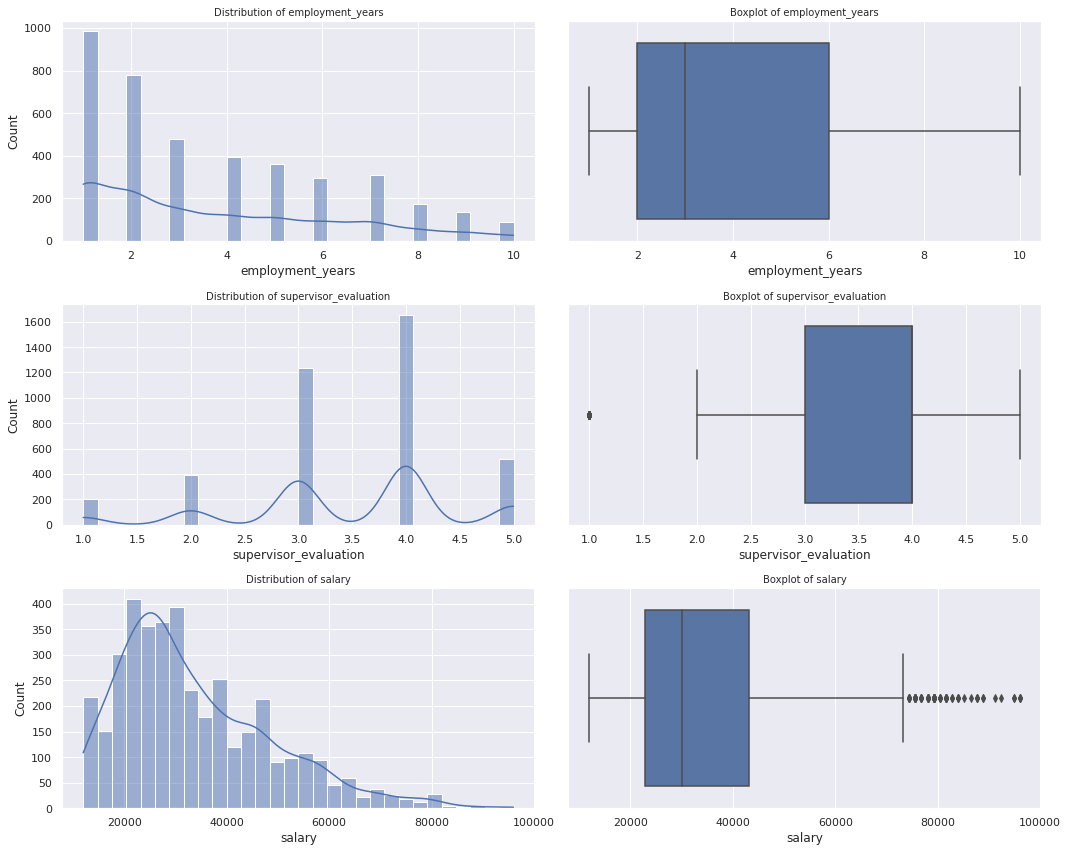

In [45]:
numerical_features = train_quit_data.select_dtypes(include=['int64', 'float64']).drop(['id'], axis=1)
quantitative_vars = numerical_features.columns

# Построим гистограммы и боксплоты для количественных переменных
fig, axes = plt.subplots(nrows=len(quantitative_vars), ncols=2,
                         figsize=(15, 4 * len(quantitative_vars)))

for i, var in enumerate(quantitative_vars):
    sns.histplot(numerical_features[var], bins=30, ax=axes[i, 0], kde=True)
    axes[i, 0].set_title(f'Distribution of {var}', fontsize=10)
    sns.boxplot(x=numerical_features[var], ax=axes[i, 1])
    axes[i, 1].set_title(f'Boxplot of {var}', fontsize=10)
    plt.tight_layout()

plt.show()

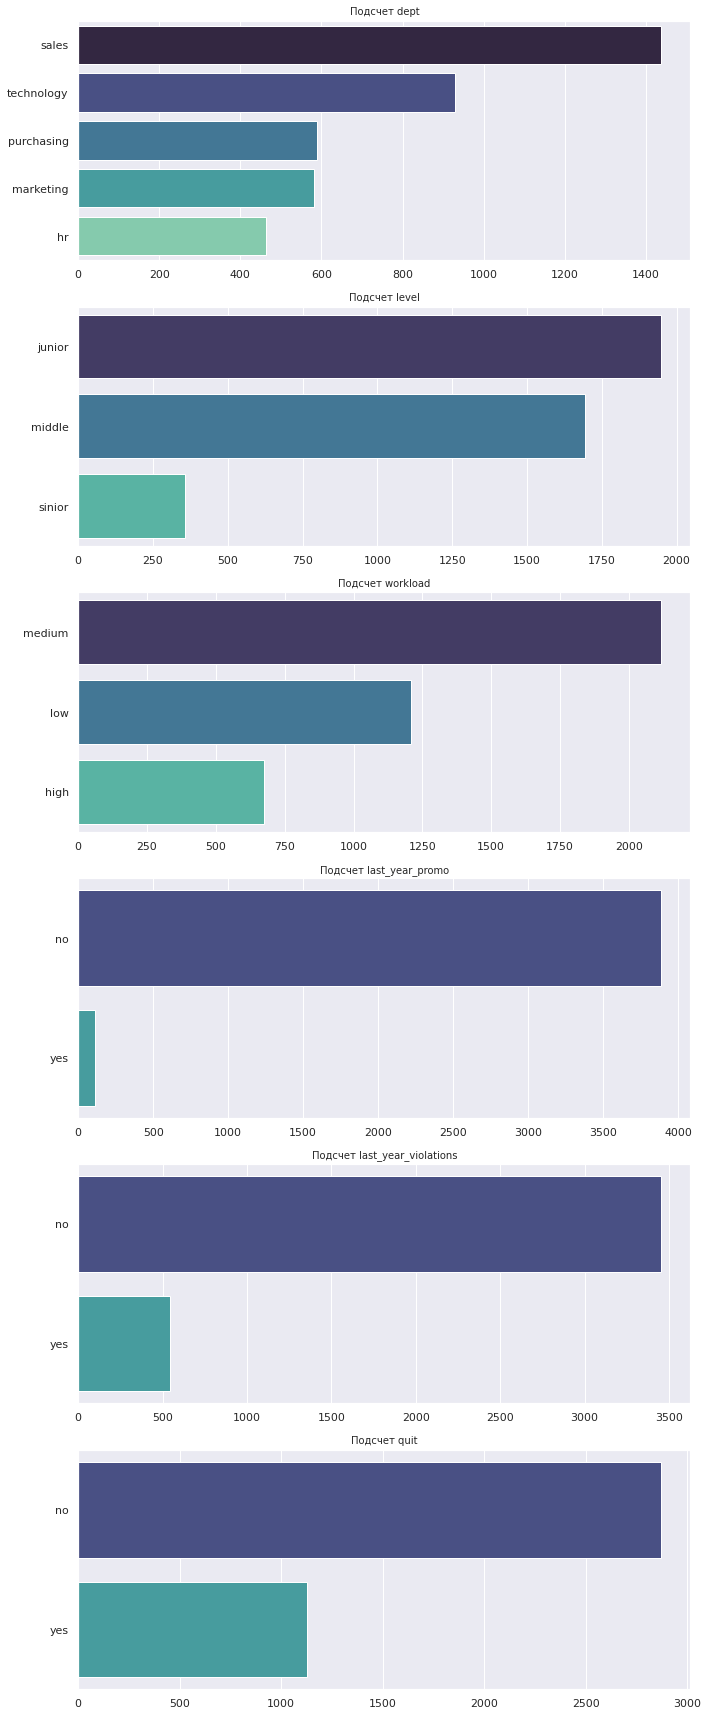

In [46]:
# Список категориальных переменных для исследования
categorical_features = train_quit_data.select_dtypes(include=['object'])
categorical_columns = categorical_features.columns

# Построим столбчатые диаграммы для категориальных переменных
fig, axes = plt.subplots(nrows=len(categorical_columns), ncols=1, figsize=(10, 4 * len(categorical_columns)))

for i, var in enumerate(categorical_columns):
    sns.countplot(y=categorical_features[var], ax=axes[i],
                  order=categorical_features[var].value_counts().index,
                  palette='mako')
    axes[i].set_title(f'Подсчет {var}', fontsize=10)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    plt.tight_layout()

plt.show()

Числовые признаки:

* employment_years: Распределение смещено влево, что указывает на большое количество сотрудников с меньшим стажем работы

* supervisor_evaluation: Преобладает оценка 4

* salary: Распределение смещено вправо, что указывает на большее количество сотрудников с нижним диапазоном зарплат

* job_satisfaction_rate: Распределение близко к равномерному, но с некоторыми пиками

Видим выбросы на Boxplot'ах, в отличии от задания 1

Категориальные признаки:

* dept: Больше всего сотрудников в отделе продаж, затем идут технологии

* level: Большинство сотрудников находятся на должности младшего уровня (junior)

* workload: Средний уровень загруженности является наиболее частым

* last_year_promo и last_year_violations: В большинстве случаев ответ "нет"

#### Тестовые данные

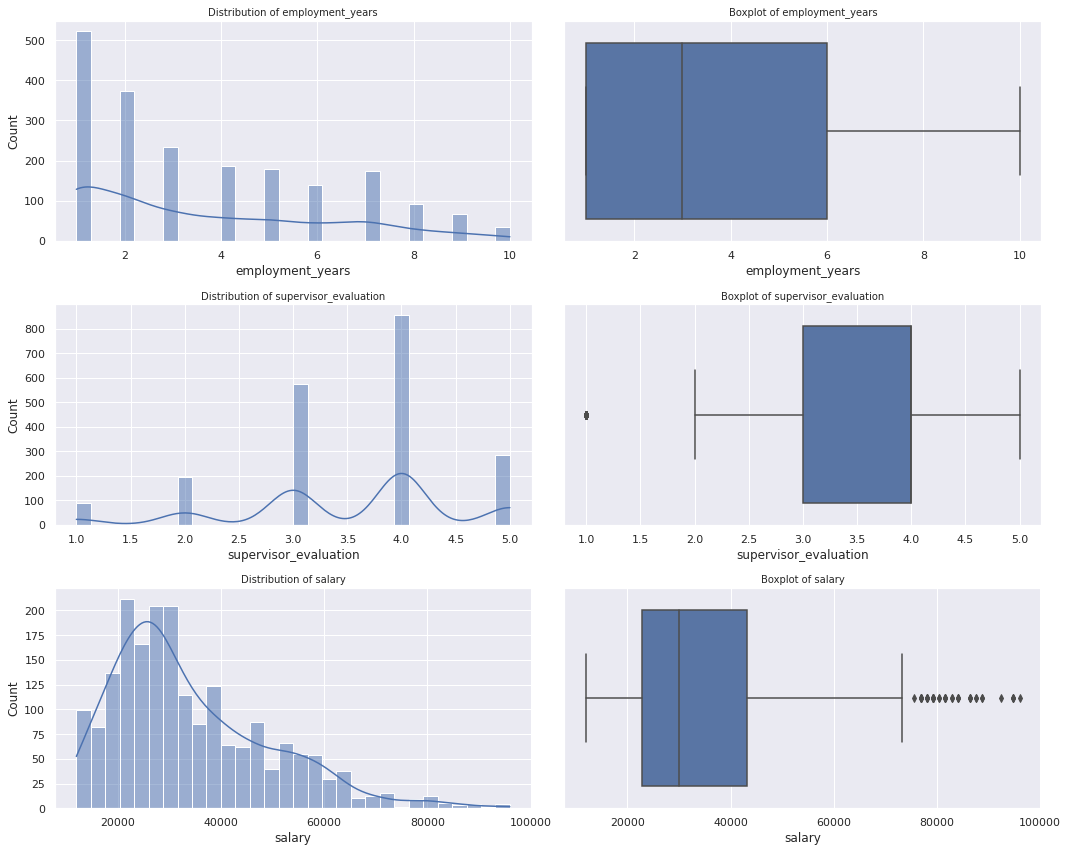

In [47]:
numerical_features = test_features.select_dtypes(include=['int64', 'float64']).drop(['id'], axis=1)
quantitative_vars = numerical_features.columns

# Построим гистограммы и боксплоты для количественных переменных
fig, axes = plt.subplots(nrows=len(quantitative_vars), ncols=2,
                         figsize=(15, 4 * len(quantitative_vars)))

for i, var in enumerate(quantitative_vars):
    sns.histplot(numerical_features[var], bins=30, ax=axes[i, 0], kde=True)
    axes[i, 0].set_title(f'Distribution of {var}', fontsize=10)
    sns.boxplot(x=numerical_features[var], ax=axes[i, 1])
    axes[i, 1].set_title(f'Boxplot of {var}', fontsize=10)
    plt.tight_layout()

plt.show()

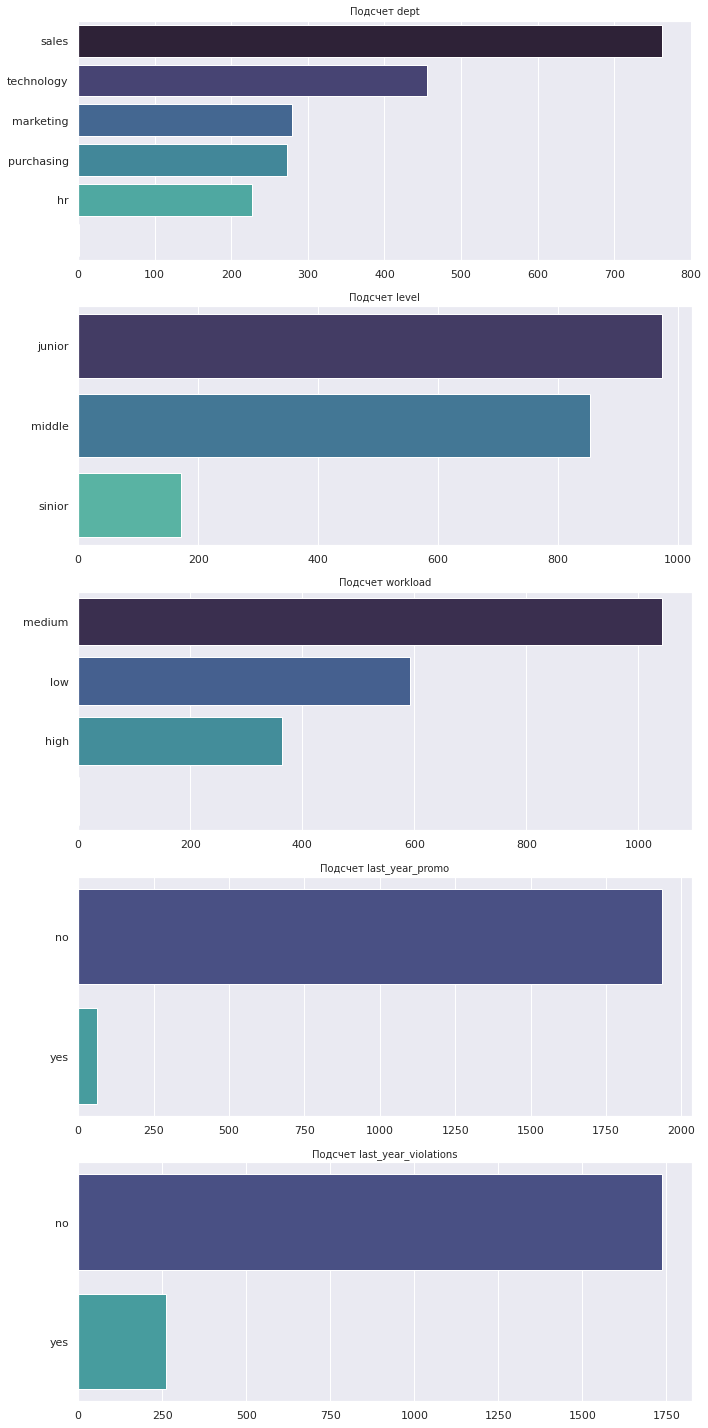

In [48]:
# Список категориальных переменных для исследования
categorical_features = test_features.select_dtypes(include=['object'])
categorical_columns = categorical_features.columns

# Построим столбчатые диаграммы для категориальных переменных
fig, axes = plt.subplots(nrows=len(categorical_columns), ncols=1, figsize=(10, 4 * len(categorical_columns)))

for i, var in enumerate(categorical_columns):
    sns.countplot(y=categorical_features[var], ax=axes[i],
                  order=categorical_features[var].value_counts().index,
                  palette='mako')
    axes[i].set_title(f'Подсчет {var}', fontsize=10)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    plt.tight_layout()

plt.show()

#### Матрица корреляции

interval columns not set, guessing: ['id', 'employment_years', 'supervisor_evaluation', 'salary']


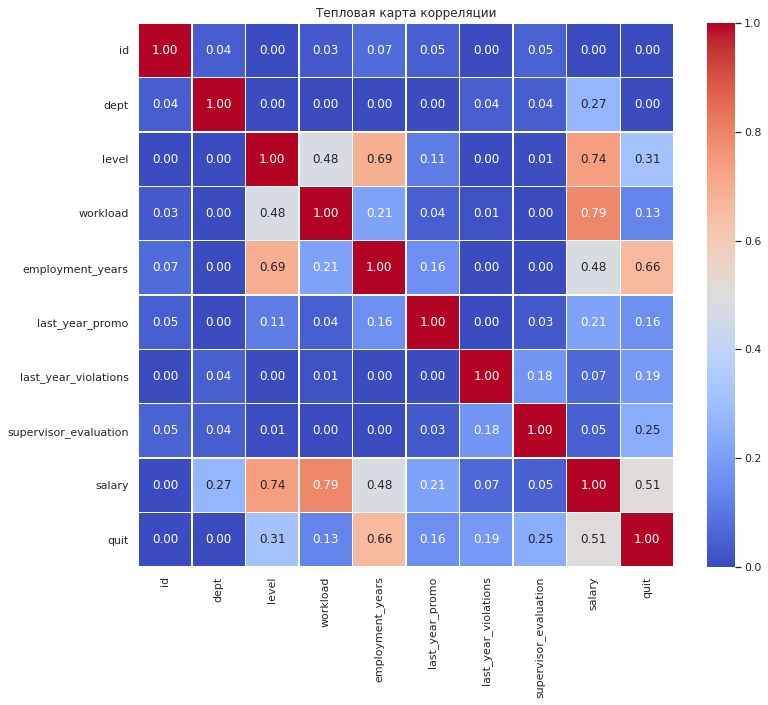

In [49]:
# Построим тепловую карту корреляций для количественных переменных
corr_matrix = train_quit_data.phik_matrix()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm",
            linewidths=0.5, fmt='.2f')
plt.title('Тепловая карта корреляции')
plt.show();

Наблюдаем положительную корреляцию между зарплатой и сроком работы, а также нагрузкой и зарплатой, что логично

### 3.2 Портрет «уволившегося сотрудника»

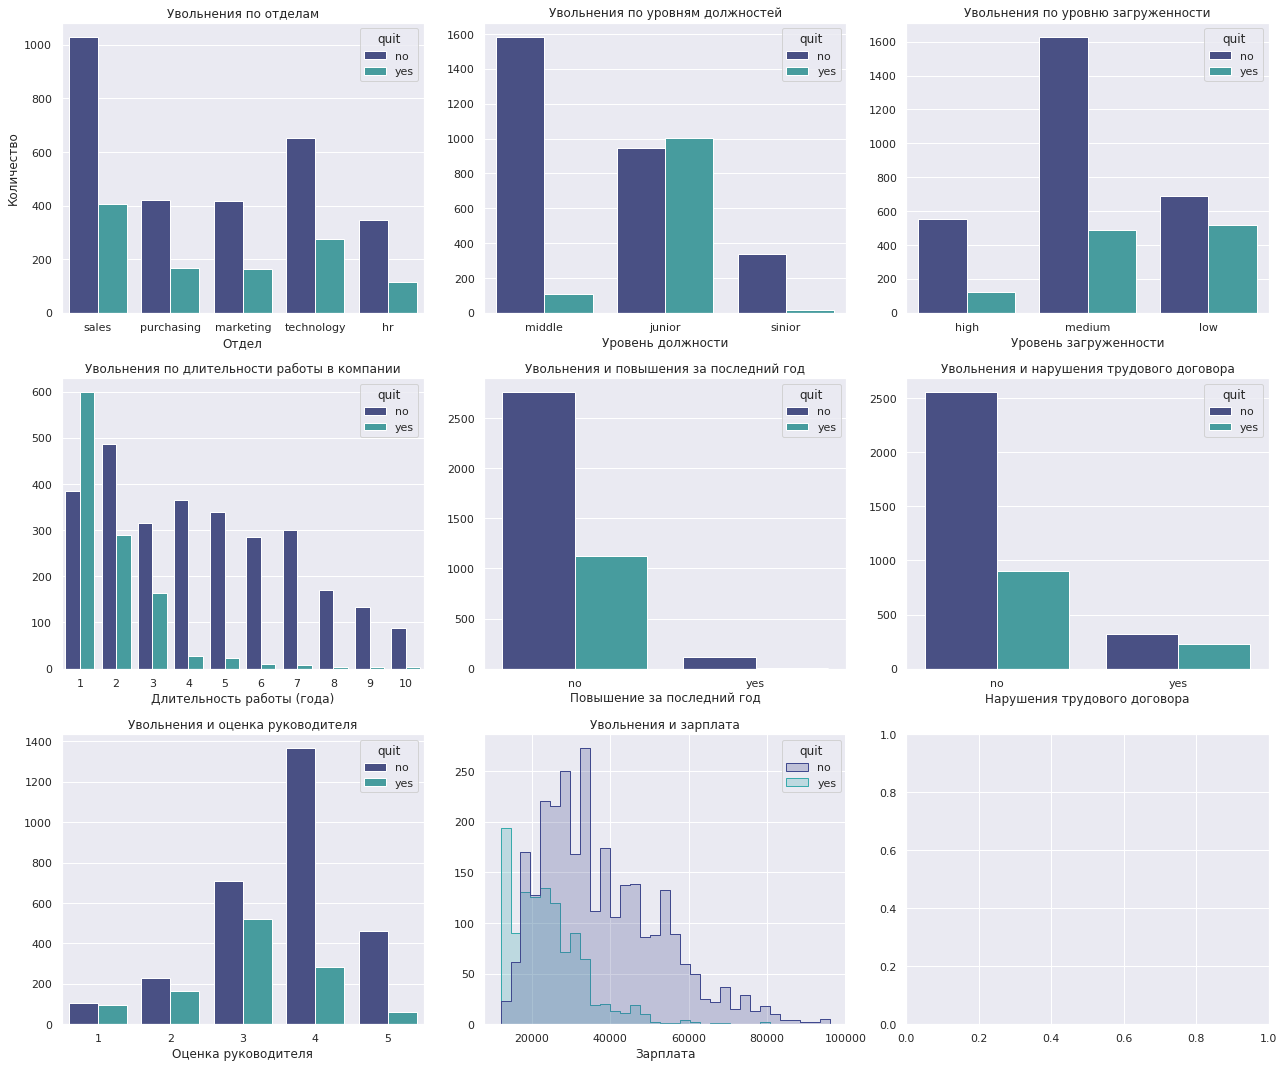

In [50]:
# Исследовательский анализ данных
fig, axes = plt.subplots(3, 3, figsize=(18, 15))

# Распределение увольнений по отделам
sns.countplot(x='dept', hue='quit', data=train_quit_data, ax=axes[0, 0],
                  palette='mako')
axes[0, 0].set_title('Увольнения по отделам')
axes[0, 0].set_xlabel('Отдел')
axes[0, 0].set_ylabel('Количество')

# Распределение увольнений по уровням должностей
sns.countplot(x='level', hue='quit', data=train_quit_data, ax=axes[0, 1],
                  palette='mako')
axes[0, 1].set_title('Увольнения по уровням должностей')
axes[0, 1].set_xlabel('Уровень должности')
axes[0, 1].set_ylabel('')

# Распределение увольнений по уровню загруженности
sns.countplot(x='workload', hue='quit', data=train_quit_data, ax=axes[0, 2],
                  palette='mako')
axes[0, 2].set_title('Увольнения по уровню загруженности')
axes[0, 2].set_xlabel('Уровень загруженности')
axes[0, 2].set_ylabel('')

# Распределение увольнений по длительности работы в компании
sns.countplot(x='employment_years', hue='quit', data=train_quit_data, ax=axes[1, 0],
                  palette='mako')
axes[1, 0].set_title('Увольнения по длительности работы в компании')
axes[1, 0].set_xlabel('Длительность работы (года)')
axes[1, 0].set_ylabel('')

# Распределение увольнений по наличию повышения за последний год
sns.countplot(x='last_year_promo', hue='quit', data=train_quit_data, ax=axes[1, 1],
                  palette='mako')
axes[1, 1].set_title('Увольнения и повышения за последний год')
axes[1, 1].set_xlabel('Повышение за последний год')
axes[1, 1].set_ylabel('')

# Распределение увольнений по наличию нарушений трудового договора за последний год
sns.countplot(x='last_year_violations', hue='quit', data=train_quit_data, ax=axes[1, 2],
                  palette='mako')
axes[1, 2].set_title('Увольнения и нарушения трудового договора')
axes[1, 2].set_xlabel('Нарушения трудового договора')
axes[1, 2].set_ylabel('')

# Распределение увольнений по оценке руководителя
sns.countplot(x='supervisor_evaluation', hue='quit', data=train_quit_data, ax=axes[2, 0],
                  palette='mako')
axes[2, 0].set_title('Увольнения и оценка руководителя')
axes[2, 0].set_xlabel('Оценка руководителя')
axes[2, 0].set_ylabel('')

# Распределение увольнений по зарплате
sns.histplot(data=train_quit_data, x='salary', hue='quit', element='step', ax=axes[2, 1],
                  palette='mako')
axes[2, 1].set_title('Увольнения и зарплата')
axes[2, 1].set_xlabel('Зарплата')
axes[2, 1].set_ylabel('')

plt.tight_layout()
plt.show()

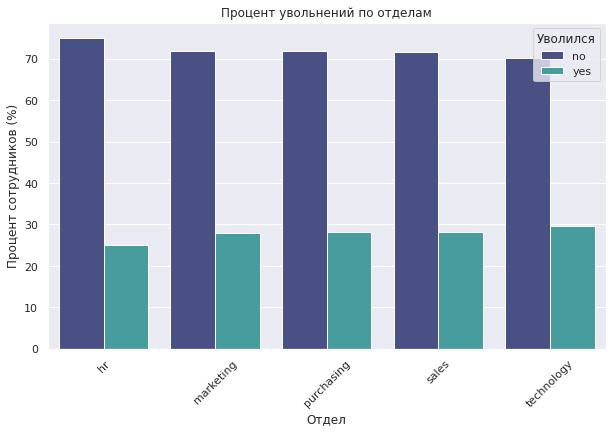

In [51]:
# Подсчёт количества увольнений и оставшихся сотрудников по отделам
dept_counts = train_quit_data.groupby('dept')['quit'].value_counts().unstack()

# Нормализация данных по отделам (преобразование в проценты)
dept_percentages = dept_counts.div(dept_counts.sum(axis=1), axis=0) * 100

# Сброс индекса для удобства визуализации
dept_percentages_reset = dept_percentages.reset_index()

# Визуализация
plt.figure(figsize=(10, 6))
sns.barplot(data=dept_percentages_reset.melt(id_vars='dept'),
            x='dept', y='value', hue='quit', palette='mako')
plt.title('Процент увольнений по отделам')
plt.xlabel('Отдел')
plt.ylabel('Процент сотрудников (%)')
plt.xticks(rotation=45)
plt.legend(title='Уволился')
plt.show()

Изучив представленные графики, можно сделать следующие выводы о характеристиках уволившихся сотрудников:

* Увольнения по отделам:

Большинство увольнений происходит в отделах продаж (sales) и технологий (technology). Это может указывать на высокую конкуренцию или напряженные условия работы в этих сферах.

* Увольнения по уровням должностей:

Сотрудники на начальных и средних должностях (junior, middle) увольняются чаще, чем сотрудники на старших должностях (senior). Это может быть связано с карьерным ростом или поиском лучших возможностей.

* Увольнения по уровню загруженности:

Сотрудники с высоким и средним уровнем загруженности увольняются чаще, чем с низким. Вероятно, это связано с балансом между работой и личной жизнью.

* Увольнения по длительности работы в компании:

Наблюдается тенденция к увольнениям среди сотрудников с длительностью работы от одного до пяти лет. Сотрудники, работающие в компании более длительный срок, увольняются реже.

* Увольнения и повышения за последний год:

Сотрудники, которые не получали повышения за последний год, увольняются значительно чаще. Это указывает на важность признания заслуг и карьерного развития для удержания персонала.

* Увольнения и нарушения трудового договора:

Сотрудники, имеющие нарушения трудового договора, склонны к увольнению, что может свидетельствовать о проблемах с дисциплиной или несоответствием требованиям компании.

* Увольнения и оценка руководителя:

Сотрудники с более низкой оценкой руководителя увольняются чаще, что подчеркивает важность управленческой поддержки и обратной связи.

* Увольнения и зарплата:

На гистограмме видно, что увольнения происходят чаще среди сотрудников с зарплатой в нижнем и среднем диапазоне. Это может указывать на то, что уровень зарплаты является значимым фактором в решении сотрудников об увольнении.

Относительно распределений в отделах разницы практически нет

### 3.3 Удовлетвореность от увольнения

In [52]:
# Объединение данных об удовлетворенности и увольнении
combined_data = test_quit_data.merge(test_target[['id',
                                                  'job_satisfaction_rate']], on='id')

In [53]:
combined_data.sample(n=5)

,id,quit,job_satisfaction_rate
1334,142469,no,0.84
1955,482515,no,0.75
1745,837150,no,0.15
616,607712,no,0.25
1256,871167,no,0.64


In [54]:
test_data = test_features.merge(test_target[['id',
                                             'job_satisfaction_rate']], on='id')

In [55]:
assert len(test_features) == len(y_pred_rf_test)

In [56]:
# К тестовым данным добавил предсказание модели
test_features['job_satisfaction_rate'] = y_pred_rf_test

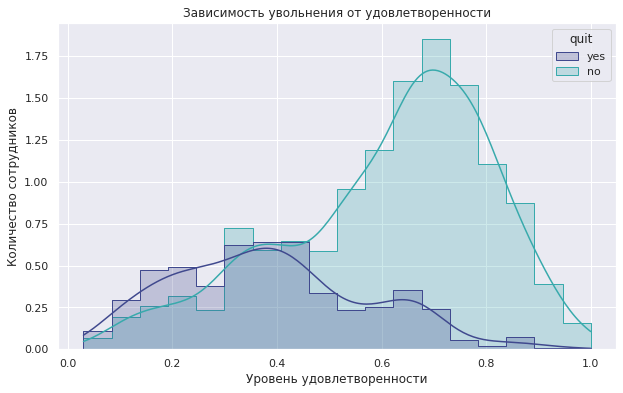

In [57]:
# Визуализация распределений уровня удовлетворенности для уволившихся и оставшихся сотрудников
plt.figure(figsize=(10, 6))
sns.histplot(data=combined_data, x='job_satisfaction_rate',
             hue='quit', kde=True, element='step',
             stat= 'density', palette='mako')
plt.title('Зависимость увольнения от удовлетворенности')
plt.xlabel('Уровень удовлетворенности')
plt.ylabel('Количество сотрудников')
plt.show()

**Вывод:**
Исходя из анализа графика можно сделатиь вывод, что большинство уволившихся сотрудников имеют низкий уровень удовлетворенности, что указывает на то, что сотрудники, которые не довольны своей работой, более склонны к увольнению

## Шаг 4. Добавление нового входного признака

In [58]:
# Разделение данных для обучения моделей
train_quit_data = train_quit_data.drop('id', axis=1).drop_duplicates()

In [59]:
# Подготовка входных данных для предсказания job_satisfaction_rate для тренировочного набора данных второй задачи
X_train_quit = preprocessor.transform(train_quit_data.drop('quit', axis=1))

# Предсказание job_satisfaction_rate для тренировочного набора данных второй задачи
predicted_job_satisfaction_rate_train = best_rf_model.predict(X_train_quit)

In [60]:
# Пример данных, что все выполняется корректно
predicted_job_satisfaction_rate_train[:5]

array([0.64744666, 0.8492615 , 0.4162298 , 0.34693833, 0.73938319])

In [61]:
# Добавление предсказанного job_satisfaction_rate к тренировочным данным второй задачи
train_quit_data['job_satisfaction_rate'] = predicted_job_satisfaction_rate_train

# Проверка первых строк с новым признаком
train_quit_data.head()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,job_satisfaction_rate
0,sales,middle,high,2,no,no,4,54000,no,0.647447
1,sales,junior,medium,2,no,no,4,27600,no,0.849262
2,purchasing,middle,medium,5,no,no,1,37200,no,0.416230
3,sales,junior,medium,2,no,yes,3,24000,yes,0.346938
4,marketing,junior,medium,2,no,no,5,25200,no,0.739383


In [62]:
X = train_quit_data.drop(['quit'], axis=1)
y = train_quit_data['quit'].apply(lambda x: 1 if x == 'yes' else 0)

## Шаг 5. Подготовка данных

In [69]:
# Определение числовых, номинальных и ранговых признаков
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns
ordinal_features = ['level', 'workload']  # Пример ранговых признаков

# Пайплайн для числовых признаков
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Пайплайн для номинальных категориальных признаков
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')), 
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Пайплайн для ранговых категориальных признаков
ordinal_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')), # Здест тоже нужен Импутер
    ('ordinal', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=5))
])

# Комбинированный пайплайн предобработки
preprocessor_t2 = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, [c for c in categorical_features if c not in ordinal_features]),
        ('ordinal', ordinal_transformer, ordinal_features)
])

# Предобработка тренировочных и валидационных данных
X_train_processed = preprocessor_t2.fit_transform(X)

In [70]:
# Проверка размерности обработанных данных
X_train_processed.shape, X.shape

((2587, 15), (2587, 9))

Новые значения игнорируются в ('onehot', OneHotEncoder(handle_unknown='ignore')), дубликаты удалены

**Вывод:**

* Подготовили данные, разбили на выборки
* Теперь в данных есть параметр job_satisfaction_rate

## Шаг 6. Обучение модели

В качестве кандидатов рассмотрим следующие модели:

* Логистическая регрессия - базовая модель для сравнения.
* Случайный лес - мощная модель на основе ансамблей.
* Градиентный бустинг (например, XGBoost) - высокоэффективная модель для многих задач классификации

Для каждой модели мы вычислим метрику ROC-AUC на валидационной выборке.

Цель - **достичь** значения ROC-AUC ≥ 0.91.

In [71]:
# Обучение модели логистической регрессии с кросс-валидацией
log_reg = LogisticRegression(random_state=42, max_iter=1000)
cv_scores = cross_val_score(log_reg, X_train_processed, y, cv=5, scoring='roc_auc')

# Средняя оценка ROC-AUC на кросс-валидации
mean_cv_roc_auc = cv_scores.mean()
print(f"Средний ROC-AUC на кросс-валидации: {mean_cv_roc_auc:.3f}")

Средний ROC-AUC на кросс-валидации: 0.911


In [67]:
# Параметры для настройки случайного леса
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Создание модели случайного леса
rf = RandomForestClassifier(random_state=42)

# Поиск лучших гиперпараметров с помощью GridSearchCV
grid_search_rf = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, scoring='roc_auc', verbose=2)
grid_search_rf.fit(X_train_processed, y)

# Лучшие параметры и ROC-AUC для случайного леса
best_rf = grid_search_rf.best_estimator_
best_params_rf = grid_search_rf.best_params_
roc_auc_rf = grid_search_rf.best_score_

best_params_rf, roc_auc_rf

In [68]:
%%time
# Параметры для настройки XGBoost
param_grid_xgb = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0]
}

# Создание модели XGBoost
xgb = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')

# Поиск лучших гиперпараметров с помощью GridSearchCV
grid_search_xgb = GridSearchCV(estimator=xgb, param_grid=param_grid_xgb, cv=3,
                               n_jobs=-1, scoring='roc_auc', verbose=2)

grid_search_xgb.fit(X_train_processed, y)

# Лучшие параметры и ROC-AUC для XGBoost
best_xgb = grid_search_xgb.best_estimator_
best_params_xgb = grid_search_xgb.best_params_
roc_auc_xgb = grid_search_xgb.best_score_

best_params_xgb, roc_auc_xgb

In [67]:
xgb = XGBClassifier(**best_params_xgb)
xgb.fit(X_train_processed, y)

/opt/conda/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[07:42:58] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.01, max_delta_step=0,
              max_depth=5, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.8,
              tree_method='exact', validate_parameters=1, verbosity=None)

### Валидационный набор

In [72]:
test_data = test_features.merge(combined_data[['id', 'quit']], on='id')

X_valid = preprocessor_t2.transform(test_data.drop(['id', 'quit'], axis=1))
y_valid = test_data['quit'].apply(lambda x: 1 if x == 'yes' else 0)

In [73]:
test_data.drop(['id', 'quit'], axis=1).shape

(2000, 9)

In [74]:
X_valid.shape

(2000, 15)

In [75]:
# Проверка ROC-AUC на тестовой выборке
y_test_val = xgb.predict_proba(X_valid)[:, 1]
roc_auc_xgb_test = roc_auc_score(y_valid, y_test_val)

roc_auc_xgb_test

0.9296299314486656

## Шаг 7. Выводы

Выводы и предложения для бизнеса:

* Уровень удовлетворенности работы влияет на вероятность увольнения сотрудника
* Модель XGBoost обеспечивает наилучшее предсказание увольнений
* Рекомендуется рассмотреть дополнительные факторы, такие как рабочая среда и возможности карьерного роста, для более глубокого анализа причин увольнений

# Выводы

В рамках проекта были решены две основные задачи: предсказание уровня удовлетворенности сотрудников и предсказание увольнений сотрудников из компании.

Обе задачи решались на основе наборов данных, включающих как числовые, так и категориальные признаки.


**Основные результаты и выводы**

* Уровень удовлетворенности и увольнения: Установлена связь между низким уровнем удовлетворенности и вероятностью увольнения сотрудника. Это подчеркивает важность мониторинга удовлетворенности сотрудников как индикатора потенциальных увольнений.

* Эффективность моделей: Наилучшие результаты для предсказания увольнений были достигнуты с помощью модели XGBoost, что подчеркивает её эффективность в задачах, связанных с классификацией.

* Рекомендации для бизнеса: Предложено использовать модели машинного обучения для прогнозирования уровня удовлетворенности и увольнений в целях оптимизации управления персоналом. Понимание этих аспектов может помочь компании своевременно идентифицировать и устранять проблемы, связанные с удовлетворенностью и текучестью кадров.

**Дополнительные шаги**

* Интеграция моделей в бизнес-процессы: Модели можно интегрировать в HR-системы для регулярного мониторинга и предоставления рекомендаций.
Расширение анализа: Возможен более глубокий анализ, учитывающий дополнительные факторы, такие как обратная связь сотрудников, рабочая среда и корпоративная культура.